In [ ]:
#Importing modules and dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(suppress=True)

In [5]:
df = pd.read_excel('preprocessed.xlsx')

In [6]:
df.shape

(396161, 9)

In [7]:
data = df

In [8]:
data.tail()

,Unnamed: 0,state,location,type,so2,no2,rspm,spm,date
396156,435734,West Bengal,ULUBERIA,RIRUO,20.0,44.0,148.0,227.394736,15-12-2015
396157,435735,West Bengal,ULUBERIA,RIRUO,17.0,44.0,131.0,227.394736,18-12-2015
396158,435736,West Bengal,ULUBERIA,RIRUO,18.0,45.0,140.0,227.394736,21-12-2015
396159,435737,West Bengal,ULUBERIA,RIRUO,22.0,50.0,143.0,227.394736,24-12-2015
396160,435738,West Bengal,ULUBERIA,RIRUO,20.0,46.0,171.0,227.394736,29-12-2015


In [9]:
data.drop('Unnamed: 0',inplace=True,axis=1)
data.drop('state',inplace=True,axis=1)
data.drop('location',inplace=True,axis=1)
data.drop('type',inplace=True,axis=1)
data.drop('date',inplace=True,axis=1)

In [10]:
data.head()

,so2,no2,rspm,spm
0,4.8,17.4,110.372334,227.394736
1,3.1,7.0,110.372334,227.394736
2,6.2,28.5,110.372334,227.394736
3,6.3,14.7,110.372334,227.394736
4,4.7,7.5,110.372334,227.394736


In [11]:
X = data.iloc[:,1:4].values
y = data.iloc[:,0].values

In [12]:
X = np.nan_to_num(X)

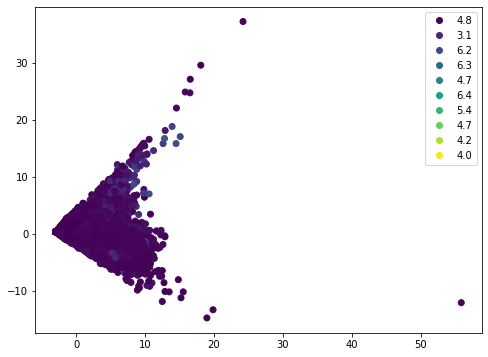

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
 

pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
plt.figure(figsize=(8,6))
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(data['so2']))
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
 

pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
plt.figure(figsize=(8,6))
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(data['so2']))
plt.show()

In [ ]:
#importing modules for building models

In [10]:
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import numpy as np
import seaborn as sns
from time import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from sklearn import metrics

In [32]:
#Splitting the data into train and test

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X,y, test_size=0.4, random_state=0)

In [12]:
print(X_train.shape, y_train.shape)

(237696, 3) (237696,)


In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [14]:
numerics =['float64']
cat=['object']

df_num=data.select_dtypes(include=numerics)
df_cat=data.select_dtypes(include=cat)
df_num =df_num.fillna('0')
df_cat=df_cat.fillna('') 
data=pd.concat([df_num, df_cat],1)
data.head()

,so2,no2,rspm,spm
0,4.8,17.4,110.372334,227.394736
1,3.1,7.0,110.372334,227.394736
2,6.2,28.5,110.372334,227.394736
3,6.3,14.7,110.372334,227.394736
4,4.7,7.5,110.372334,227.394736


## Decision tree regressor

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 108.386, test: 107.656
R^2 train: 0.125, test: 0.125


## Random forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X_train,y_train)

RandomForestRegressor()

In [17]:
print("Coefficient of determination R^2 <-- on train set: {}".format(regressor.score(X_train, y_train)))

Coefficient of determination R^2 <-- on train set: 0.6003325451023566


In [18]:
print("Coefficient of determination R^2 <-- on test set: {}".format(regressor.score(X_test, y_test)))

Coefficient of determination R^2 <-- on test set: 0.14125476949587457


In [19]:
#using cross_validation to get the generalized score of the model
from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,X,y,cv=5)
score.mean()

-0.24558227694691687

In [20]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
regressor = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

param_distributions = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf
}

In [21]:
tuned_regressor = HalvingGridSearchCV(regressor,param_distributions,cv =5)

In [22]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [23]:
model = RandomForestRegressor(n_estimators= 200,min_samples_split = 10,min_samples_leaf= 5,max_features= 'auto',max_depth= 30)
model.fit(X_train,y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=200)

C:\Users\Anusha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

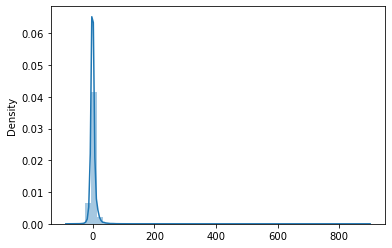

In [24]:
#predicted values
y_pred=model.predict(X_test)
sns.distplot(y_test-y_pred)

In [25]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


MAE: 5.369520205449798
MSE: 98.77511860907202
RMSE: 9.938567231199476


## Linear regression

In [26]:
data.corr()

,so2,rspm,spm
so2,1.000000,0.147818,0.092329
rspm,0.147818,1.000000,0.453659
spm,0.092329,0.453659,1.000000


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396161 entries, 0 to 396160
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   so2     396161 non-null  float64
 1   no2     396161 non-null  object 
 2   rspm    396161 non-null  float64
 3   spm     396161 non-null  float64
dtypes: float64(3), object(1)
memory usage: 12.1+ MB


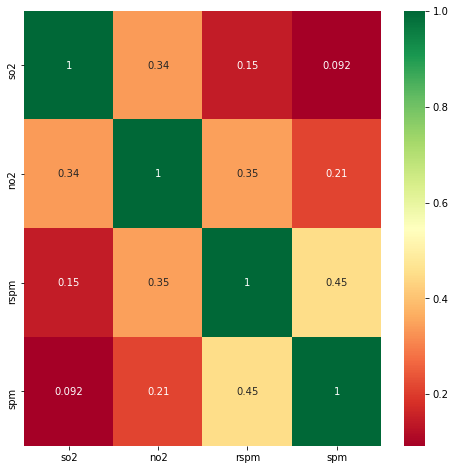

In [28]:
plt.figure(figsize=(8,8))
g=sns.heatmap(df.corr(),annot=True,cmap="RdYlGn")

In [29]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
regressor=LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression()

In [32]:
#weights / slope values
regressor.coef_

array([3.57597291, 0.35054201, 0.12576006])

In [33]:
#bias
regressor.intercept_

10.793918859242703

In [34]:
print("Coefficient of determination R^2 <-- on train set: {}".format(regressor.score(X_train, y_train)))

print("Coefficient of determination R^2 <-- on test set: {}".format(regressor.score(X_test, y_test)))

Coefficient of determination R^2 <-- on train set: 0.11316560904886042
Coefficient of determination R^2 <-- on test set: 0.11842009188914893


In [35]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,X,y,cv=5)

In [36]:
score.mean()

0.008841087699279404

In [37]:
coeff_df = pd.DataFrame(regressor.coef_,columns=['Coefficient'])
coeff_df

,Coefficient
0,3.575973
1,0.350542
2,0.125760


In [38]:
#predicted values
y_pred=regressor.predict(X_test)

C:\Users\Anusha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

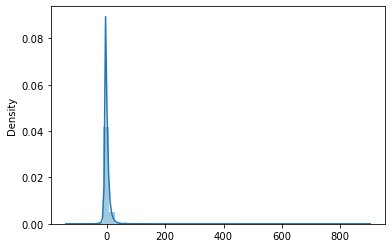

In [39]:
sns.distplot(y_test-y_pred)

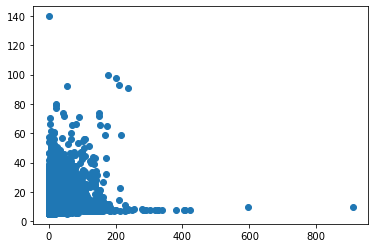

In [40]:
plt.scatter(y_test,y_pred)

In [41]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 5.96832677196083
MSE: 108.51940915698776
RMSE: 10.417264955687157


## Lasso regression

In [42]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import Lasso
lasso = Lasso()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
lasso_reg = HalvingGridSearchCV(lasso,parameters,scoring = 'neg_mean_squared_error',cv = 5)
lasso_reg.fit(X,y)

C:\Users\Anusha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1719858.9788329748, tolerance: 494.45022580495146
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anusha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1856190.412286748, tolerance: 508.79701001744394
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anusha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1445534.0885033421, tolerance: 345.8674821350545
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anusha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergen

HalvingGridSearchCV(estimator=Lasso(),
                    param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1,
                                          5, 10, 20, 30, 35, 40]},
                    refit=<function _refit_callable at 0x0000022385C3A4C0>,
                    scoring='neg_mean_squared_error')

In [43]:
print(lasso_reg.best_params_)
print(lasso_reg.best_score_)

{'alpha': 10}
-117.45931850003053


C:\Users\Anusha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

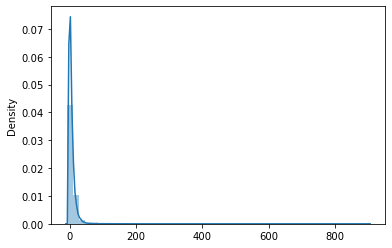

In [44]:
#predicted values
y_pred=lasso_reg.predict(X_test)
sns.distplot(y_test-y_pred)

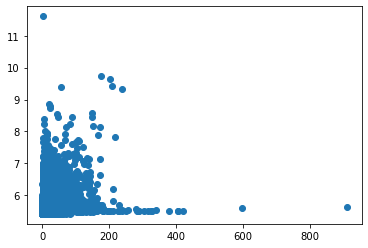

In [45]:
plt.scatter(y_test,y_pred)

In [46]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 6.468867638245367
MSE: 147.31979302491695
RMSE: 12.137536530322656


## XGBoostRegressor

In [48]:
!pip install xgboost
import xgboost as xgb
regressor = xgb.XGBRegressor()
regressor.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [49]:
print("Coefficient of determination R^2 <-- on train set: {}".format(regressor.score(X_train, y_train)))

Coefficient of determination R^2 <-- on train set: 0.2753580365581205


In [50]:
print("Coefficient of determination R^2 <-- on test set: {}".format(regressor.score(X_test, y_test)))

Coefficient of determination R^2 <-- on test set: 0.21192646253710257


In [51]:
#using cross_validation to get the generalized score of the model
from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,X,y,cv=5)
score.mean()

-0.04160903850638446

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
regressor = xgb.XGBRegressor()

In [53]:
# Number of trees in xgboost
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Various learning rate parameters
learning_rate = ['0.05','0.1', '0.2','0.3','0.5','0.6']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
#Subssample parameter values
subsample=[0.7,0.6,0.8]
# Minimum child weight parameters
min_child_weight=[3,4,5,6,7]

param_distributions = {
    'n_estimators':n_estimators,
    'learning_rate':learning_rate,
    'max_depth':max_depth,
    'subsample':subsample,
    'min_child_weight':min_child_weight
}
random = HalvingGridSearchCV(regressor,param_distributions,cv =5)

C:\Users\Anusha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

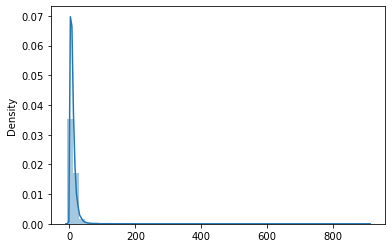

In [54]:
#predicted values
y_pred=model.predict(X_test)
sns.distplot(y_test-y_pred)

In [55]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2Score:', model.score(X_test,y_test))

MAE: 10.263400690344707
MSE: 224.9279854945611
RMSE: 14.997599324377255
R2Score: -0.8272491006378249
